In [1]:
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import ModelCheckpoint
import warnings
warnings.filterwarnings('ignore')

In [2]:
print(tf.config.list_physical_devices('GPU'))

[]


In [2]:
dataset_path = "../resources/waste_img/DATASET"

In [3]:
train_dir = os.path.join(dataset_path, "TRAIN")
test_dir = os.path.join(dataset_path, "TEST")

In [4]:
os.listdir(train_dir)

['O', 'R']

In [5]:
train_r_dir = os.path.join(train_dir, "R")
train_o_dir = os.path.join(train_dir, "O")

In [6]:
r_index = 5680
o_index = 1594

In [7]:
recyclable_imgs = [os.path.join(train_r_dir, filename) for filename in os.listdir(train_r_dir)]
organic_imgs = [os.path.join(train_o_dir, filename) for filename in os.listdir(train_o_dir)]

In [8]:
img_r = mpimg.imread(recyclable_imgs[r_index])
img_o = mpimg.imread(organic_imgs[o_index])

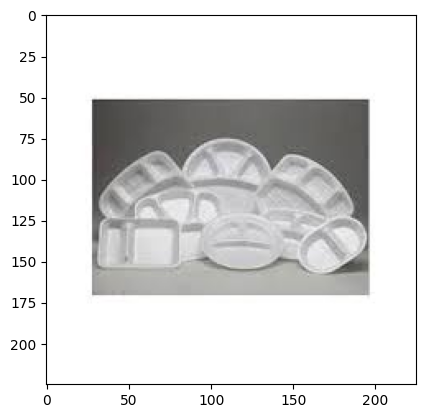

In [9]:
plt.imshow(img_r)

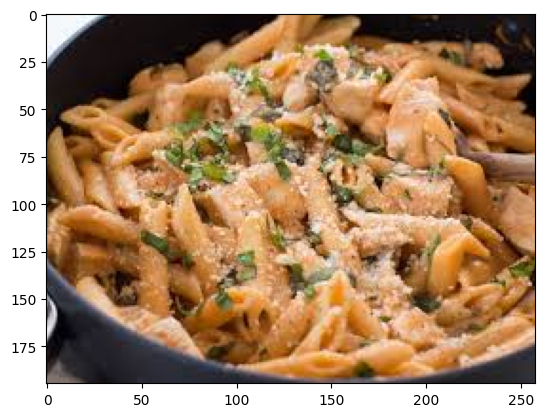

In [10]:
plt.imshow(img_o)

# ImageDataGenerator

In [11]:

from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [12]:

train_data_generator = ImageDataGenerator(rescale=1/255.0)

test_data_generator = ImageDataGenerator(rescale=1/255.0)

In [13]:
train_generator = train_data_generator.flow_from_directory(
    directory = train_dir,
    target_size = (224, 224),
    batch_size=32,
    class_mode="binary"

)


test_generator = test_data_generator.flow_from_directory(
    directory = test_dir,
    target_size = (224, 224),
    batch_size=32,
    class_mode="binary"

)


Found 22564 images belonging to 2 classes.
Found 2513 images belonging to 2 classes.


In [14]:
train_generator.class_indices

{'O': 0, 'R': 1}

# Model

In [15]:

model = tf.keras.models.Sequential([

    #Extraction de caractéristiques
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), padding="same", activation='relu', input_shape=(224, 224,3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation="relu"),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation="relu"),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation="relu"),
    tf.keras.layers.MaxPooling2D(2,2),

    # applatir
    tf.keras.layers.Flatten(),

    # Dense
    tf.keras.layers.Dense(units=128, activation="relu"),
    tf.keras.layers.Dense(units=1, activation="sigmoid"),
                ])

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 110, 110, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 55, 55, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 53, 53, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 26, 26, 128)       0

In [17]:
model_ckp = tf.keras.callbacks.ModelCheckpoint(filepath="best_model.h5",
                            monitor="val_accuracy",
                            mode="max",
                            save_best_only=True)
stop = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=3, restore_best_weights=True)

In [18]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
              loss="binary_crossentropy",
              metrics=['accuracy'])

In [19]:
gpu = tf.config.experimental.list_physical_devices("GPU")
print(tf.test.is_gpu_available())

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
False


In [20]:
h = model.fit(train_generator, epochs=50,
             validation_data=test_generator,
             callbacks = [model_ckp, stop])

Epoch 1/50


706/706 [==============================] - 292s 412ms/step - loss: 0.4601 - accuracy: 0.8059 - val_loss: 0.3511 - val_accuracy: 0.8579
Epoch 2/50
706/706 [==============================] - 286s 406ms/step - loss: 0.3721 - accuracy: 0.8437 - val_loss: 0.3025 - val_accuracy: 0.8961
Epoch 3/50
706/706 [==============================] - 275s 389ms/step - loss: 0.3404 - accuracy: 0.8610 - val_loss: 0.2909 - val_accuracy: 0.8906
Epoch 4/50
706/706 [==============================] - 275s 390ms/step - loss: 0.3193 - accuracy: 0.8713 - val_loss: 0.2995 - val_accuracy: 0.8842
Epoch 5/50
706/706 [==============================] - 276s 390ms/step - loss: 0.3019 - accuracy: 0.8788 - val_loss: 0.3521 - val_accuracy: 0.8826


In [21]:
def plot_loss_curve(history):


  plt.plot(list(range(len(history['loss']))), history['loss'], label = "loss")
  plt.plot(list(range(len(history['val_loss']))), history['val_loss'], label="val_loss")
  plt.xlabel('Epochs')
  plt.ylabel("Loss")
  plt.title("Loss Curve")
  plt.legend(loc='upper right')
  plt.show()

def plot_accuracy_curve(history):


  plt.plot(list(range(len(history['accuracy']))), history['accuracy'], label = "accuracy")
  plt.plot(list(range(len(history['val_accuracy']))), history['val_accuracy'], label="val_accuracy")
  plt.xlabel('Epochs')
  plt.ylabel("accuracy")
  plt.title("Accuracy Curve")
  plt.legend(loc='upper right')
  plt.show()

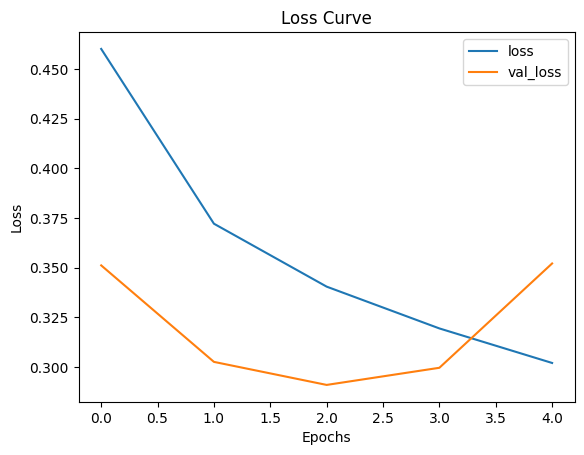

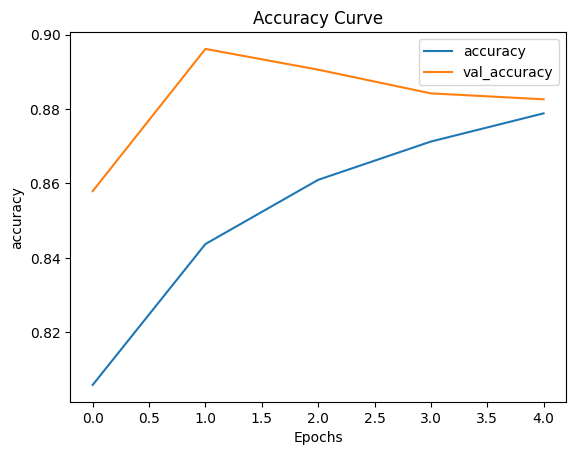

In [22]:
plot_loss_curve(h.history)
plot_accuracy_curve(h.history)


# Fine tunning

In [23]:

model = tf.keras.models.Sequential([

    #Extraction de caractéristiques
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), padding="same", activation='relu', input_shape=(224, 224,3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation="relu"),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation="relu"),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation="relu"),
    tf.keras.layers.MaxPooling2D(2,2),

    # applatir
    tf.keras.layers.Flatten(),

    # Dense
    tf.keras.layers.Dense(units=128, activation="relu"),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(units=1, activation="sigmoid"),
                ])

In [24]:
model_ckp = tf.keras.callbacks.ModelCheckpoint(filepath="ft_model.h5",
                            monitor="val_accuracy",
                            mode="max",
                            save_best_only=True)
stop = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=3, restore_best_weights=True)

In [25]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001),
              loss="binary_crossentropy",
              metrics=['accuracy'])

In [26]:
h1 = model.fit(train_generator, epochs=50,
             validation_data=test_generator,
             callbacks = [model_ckp, stop])

Epoch 1/50
706/706 [==============================] - 328s 463ms/step - loss: 0.5073 - accuracy: 0.7610 - val_loss: 0.5192 - val_accuracy: 0.8384
Epoch 2/50
706/706 [==============================] - 334s 473ms/step - loss: 0.4316 - accuracy: 0.8105 - val_loss: 0.5060 - val_accuracy: 0.7509
Epoch 3/50
706/706 [==============================] - 333s 472ms/step - loss: 0.4028 - accuracy: 0.8274 - val_loss: 0.4876 - val_accuracy: 0.7708
Epoch 4/50
706/706 [==============================] - 334s 473ms/step - loss: 0.3830 - accuracy: 0.8376 - val_loss: 0.4693 - val_accuracy: 0.7831


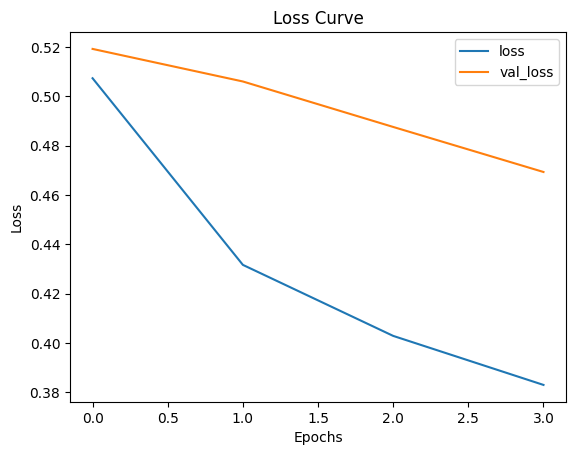

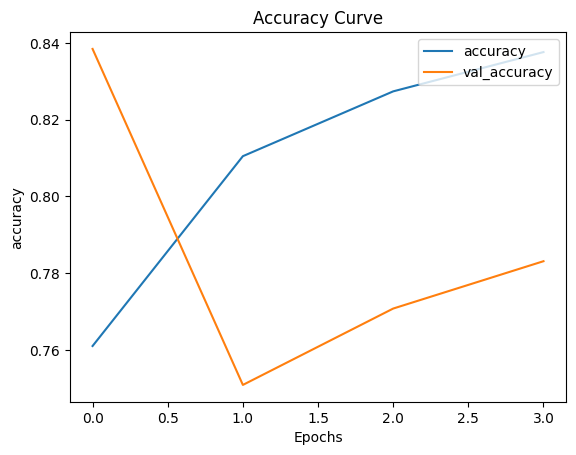

In [27]:
plot_loss_curve(h1.history)
plot_accuracy_curve(h1.history)

In [28]:
# loss: 0.2348 - accuracy: 0.9042 - val_loss: 0.2471 - val_accuracy: 0.9017
# loss: 0.4092 - accuracy: 0.8239 - val_loss: 0.5584 - val_accuracy: 0.6789

Epoch 1/50
706/706 [==============================] - 320s 453ms/step - loss: 0.4965 - accuracy: 0.7678 - val_loss: 0.5037 - val_accuracy: 0.7608
Epoch 2/50
706/706 [==============================] - 315s 447ms/step - loss: 0.4316 - accuracy: 0.8089 - val_loss: 0.5184 - val_accuracy: 0.7008
Epoch 3/50
706/706 [==============================] - 316s 447ms/step - loss: 0.4001 - accuracy: 0.8286 - val_loss: 0.4867 - val_accuracy: 0.7692
Epoch 4/50
706/706 [==============================] - 321s 455ms/step - loss: 0.3777 - accuracy: 0.8373 - val_loss: 0.4025 - val_accuracy: 0.8337
Epoch 5/50
706/706 [==============================] - 327s 463ms/step - loss: 0.3584 - accuracy: 0.8507 - val_loss: 0.4784 - val_accuracy: 0.7855
Epoch 6/50
706/706 [==============================] - 318s 450ms/step - loss: 0.3429 - accuracy: 0.8581 - val_loss: 0.4418 - val_accuracy: 0.8173
Epoch 7/50
706/706 [==============================] - 323s 457ms/step - loss: 0.3284 - accuracy: 0.8636 - val_loss: 0.3320 -

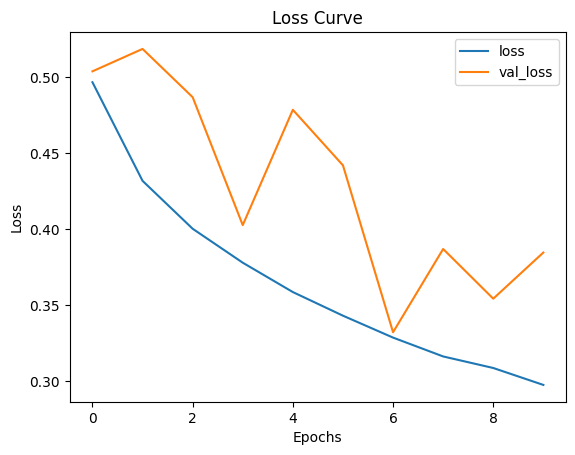

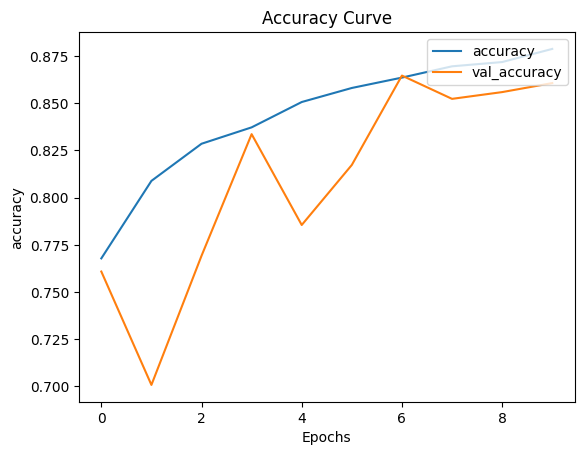

In [29]:
model = tf.keras.models.Sequential([

    #Extraction de caractéristiques
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), padding="same", activation='relu',
                           input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation="relu"),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation="relu"),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation="relu"),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.5),
    # applatir
    tf.keras.layers.Flatten(),

    # Dense
    tf.keras.layers.Dense(units=128, activation="relu"),
    tf.keras.layers.Dense(units=1, activation="sigmoid"),
])
model_ckp = tf.keras.callbacks.ModelCheckpoint(filepath="ft_model.h5",
                                               monitor="val_accuracy",
                                               mode="max",
                                               save_best_only=True)
stop = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=3, restore_best_weights=True)
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001),
              loss="binary_crossentropy",
              metrics=['accuracy'])
h2 = model.fit(train_generator, epochs=50,
               validation_data=test_generator,
               callbacks=[model_ckp, stop])
plot_loss_curve(h2.history)
plot_accuracy_curve(h2.history)

In [30]:
# loss: 0.2348 - accuracy: 0.9042 - val_loss: 0.2471 - val_accuracy: 0.9017
# loss: 0.4092 - accuracy: 0.8239 - val_loss: 0.5584 - val_accuracy: 0.6789
# loss: 0.3813 - accuracy: 0.8345 - val_loss: 0.4319 - val_accuracy: 0.8181

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 112, 112, 32)      0         
 ng2D)                                                           
                                                                 
 conv2d_13 (Conv2D)          (None, 110, 110, 64)      18496     
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 55, 55, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_14 (Conv2D)          (None, 53, 53, 128)       73856     
                                                                 
 max_pooling2d_14 (MaxPooli  (None, 26, 26, 128)      

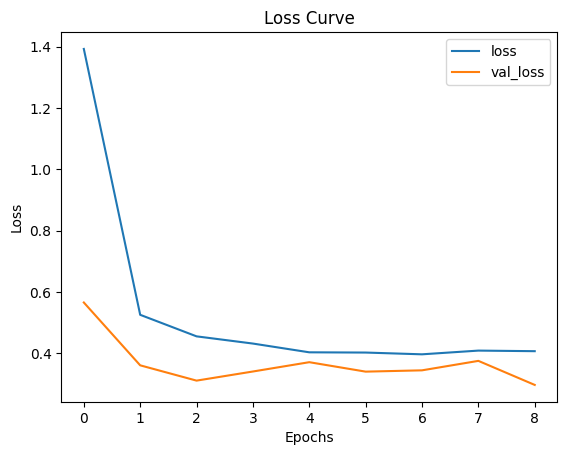

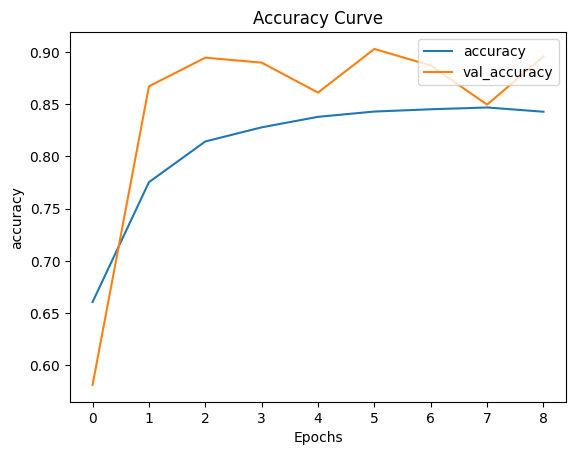

In [31]:
model = tf.keras.models.Sequential([

    #Extraction de caractéristiques
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), padding="same", activation='relu',
                           input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation="relu"),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation="relu"),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation="relu"),
    tf.keras.layers.MaxPooling2D(2, 2),

    # applatir
    tf.keras.layers.Flatten(),

    # Dense
    tf.keras.layers.Dense(units=128, activation="relu"),
    tf.keras.layers.Dense(units=1, activation="sigmoid"),
])
model.summary()
model_ckp = tf.keras.callbacks.ModelCheckpoint(filepath="best_model.h5",
                                               monitor="val_accuracy",
                                               mode="max",
                                               save_best_only=True)
stop = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=3, restore_best_weights=True)
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.01),
              loss="binary_crossentropy",
              metrics=['accuracy'])

h3 = model.fit(train_generator, epochs=50,
               validation_data=test_generator,
               callbacks=[model_ckp, stop])
plot_loss_curve(h3.history)
plot_accuracy_curve(h3.history)

In [33]:
print(tf.config.list_physical_devices('GPU'))

[]
